In [1]:
import random as rand
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
class QUESTION:
    """
    Class that represents enumerate for questions
    """
    q1 = 1
    q2_1 = 2.1
    q2_2 = 2.2
    q3 = 3

In [3]:
# images paths
FINGER_IMAGE = "images/finger.jpg"
FINGER_CUT_IMAGE = "images/finger_cut.jpg"
PHOTOS_OUTPUT_PATH = "images/output"
SAVE_PHOTOS = True
PHOTO_NAME_COUNTER = 1
PHOTO_NAME_COUNTER_PLOT = 1

### Util Functions:

In [4]:
def create_point(cir_r, cir_x, cir_y, question: float):
    """
    Create point data of (x, y)
    """
    while True:
        if question == QUESTION.q3:
            n = np.random.uniform(-2, 2)
        else:
            n = np.random.rand()
        alpha = 2 * np.pi * n
        r = cir_r * np.sqrt(np.random.rand())
        
        # calculating coordinates
        x = r * np.cos(alpha) + cir_x
        y = r * np.sin(alpha) + cir_y
        if (not 2 <= x**2 + y**2 <= 4) and question == QUESTION.q3:
            continue
        return (x, y)

def create_map(row, col, question: float):
    """
    Create Map
    """
    Map = np.empty(shape = (row, col, 2))
    for i in range(row):
        for j in range(col):
            if question == QUESTION.q1:
                x = np.random.rand()
                y = np.random.rand()
            elif question == QUESTION.q2_1:
                x = np.random.pareto(1)
                if x >= 1:
                    x = 1 / x
                y = np.random.rand()
            elif question == QUESTION.q2_2:
                x = np.random.normal(loc=0.5, scale=0.20, size=None)
                y = np.random.normal(loc=0.5, scale=0.20, size=None)
            elif question == QUESTION.q3:
                x, y = create_point(-1.414, 0, 0, 1)
            Map[i][j][0] = x
            Map[i][j][1] = y
    return Map

def create_data(size: int, question: float = 1):
    """
    Create data (array of points)
    """
    data = []
    circle_x = circle_y = circle_r = 0.5
    while len(data) < size:
        if question == QUESTION.q3:
            data.append(create_point(2, 0, 0, question))
        else:
            data.append(create_point(0.5, 0.5 ,0.5, question))
    return np.array(data)

def create_hand(path: str):
    """
    Create hand for part B
    """
    img = cv2.imread(path, 0)
    x, y = np.where(img < 240)
    data = (1 - np.array((x,y)).T)
    y = data[:, 0]
    y = y / min(y)
    y = 1 - y
    x = data[:,1]
    x = x / min(x)
    x = 1 - x
    return np.array((x,y)).T

In [5]:
img = cv2.imread(FINGER_IMAGE, 0)
cv2.imshow('what', img)
x, y = np.where(img < 240)
data = (1 - np.array((x,y)).T)
y = data[:, 0]
y = y / min(y)
y = 1 - y
x = data[:,1]
x = x / min(x)
x = 1 - x

In [6]:
def plot_Map(Map, data_p, question: float = None, plot_number: int = None):
    """
    Plotting a given map and data
    """
    # get x, y data
    x = data[:,0]
    y = data[:,1]
    plt.scatter(x, y, alpha=0.4)
        
    # shape is equl to 2 dimensions
    if len(Map.shape) == 2:
        m_x = Map[:,:,0]
        m_y = Map[:,:,1]
        plt.scatter(m_x, m_y, alpha = 1, color='black')
        plt.plot(m_x, m_y, alpha = 1, color='red')
        
    # shape is bigger than 2 dimensions
    elif len(Map.shape) > 2:
        for i in range(Map.shape[1]):
            m_x = Map[:,i,0]
            m_y = Map[:,i,1]
            plt.scatter(m_x, m_y, alpha=1, color='black')
            plt.plot(m_x, m_y, alpha = 1)
        for j in range(Map.shape[2]):
            m_x = Map[j,:,0]
            m_y = Map[j,:,1]
            plt.scatter(m_x, m_y, alpha=1, color = 'black')
            plt.plot(m_x, m_y, alpha=1)
            
    # saving photo if needed
    global SAVE_PHOTOS
    global PHOTO_NAME_COUNTER_PLOT
    if SAVE_PHOTOS:
        global PHOTO_NAME_COUNTER
        global PHOTOS_OUTPUT_PATH
        description = f"plot_{PHOTO_NAME_COUNTER_PLOT}_number_{plot_number}_figure_{PHOTO_NAME_COUNTER}_question_{str(question)}"
        plt.title(description)
        plt.savefig(f"{PHOTOS_OUTPUT_PATH}/{description}.png")
        PHOTO_NAME_COUNTER += 1
    plt.show()

In [7]:
def find_BMU(Map,x):
    """
    Find BMU
    """
    distSq = (np.square(Map - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

def update_weights(Map, train_row, learn_rate, radius_sq, row, col, step=3):
    """
    Update weights of Map
    """
    # if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        Map[row,col,:] += learn_rate * (train_row - Map[row,col,:])
        return Map
    
    # change all cells in a small neighborhood of BMU
    rows_max = max(0, row-step)
    rows_min = min(Map.shape[0], row + step)
    cols_max = max(0, col-step)
    cols_min = min(Map.shape[1], col + step)
    for i in range(rows_max,rows_min):
        for j in range(cols_max,cols_min):
            # lateral distance
            late_dist = np.square(i - row) + np.square(j - col)
            
            # topological neighborhood
            top_neighbs = np.exp(-late_dist / 2 /radius_sq)
            
            # sigma weights
            Map[i,j,:] += learn_rate * top_neighbs * (train_row - Map[i,j,:])
    return Map

In [8]:
def train(Map, data, iterations, lr, radi, lr_dec, rad_dec, question: float = None):
    """
    Train Map
    """
    Map_prev = np.copy(Map)
    lr_0 = lr
    radius_0 = radi
    global PHOTO_NAME_COUNTER_PLOT
    plot_number = 1
    for it in range(iterations):
        if it % 100 == 0:
            plot_Map(Map, data, question, plot_number)
            plot_number += 1
        np.random.shuffle(data)
        for row in data:
            r,c = find_BMU(Map, row)
            Map = update_weights(Map, row, lr, radi, r,c)
        lr = lr_0 * np.exp(-it * lr_dec)
        radi = radius_0 * np.exp(-(it * rad_dec))
    PHOTO_NAME_COUNTER_PLOT += 1

## Part A :

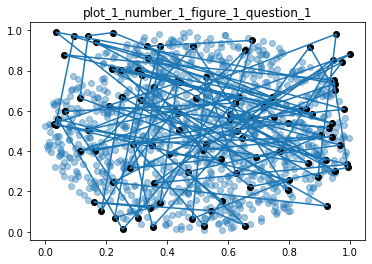

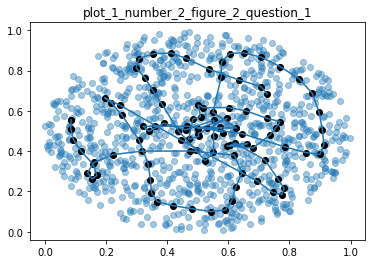

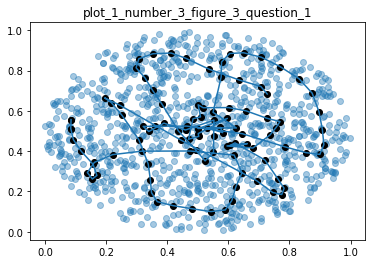

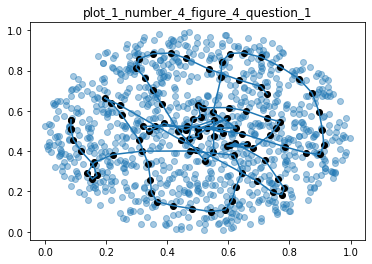

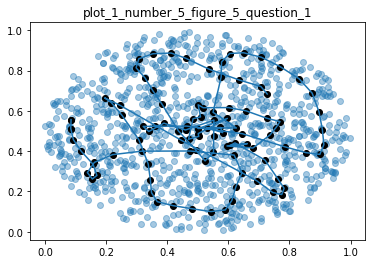

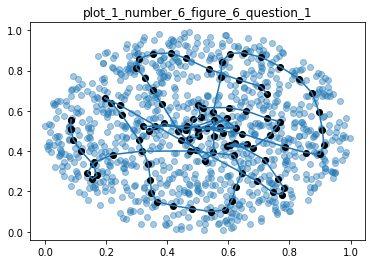

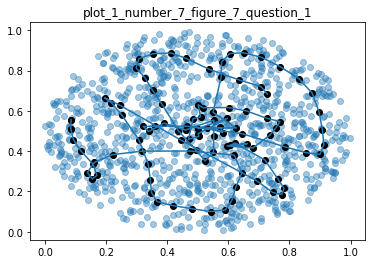

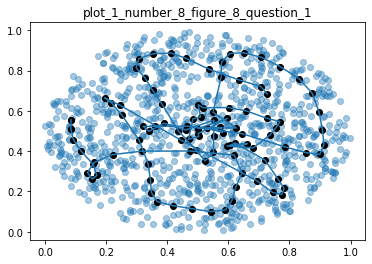

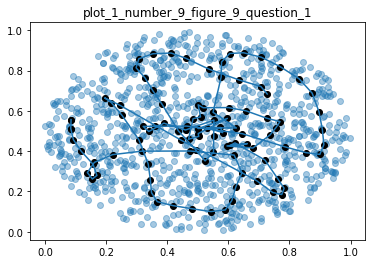

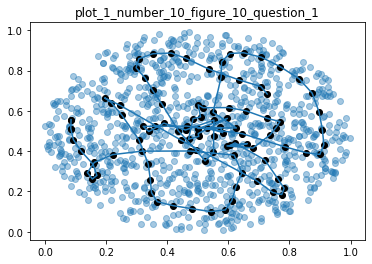

In [9]:
# Question 1 - for 100 neirons
CURRENT_QUESTION = 1
data = create_data(1000)
Map = create_map(100, 1, CURRENT_QUESTION)
lr_decay = 0.1
radius_decay = 0.1
iterations = 1000
lr = 0.01
radius = 8
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

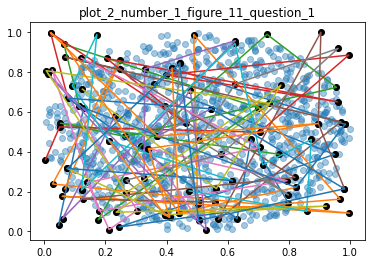

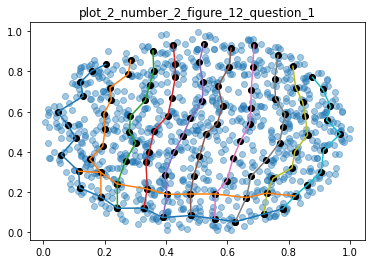

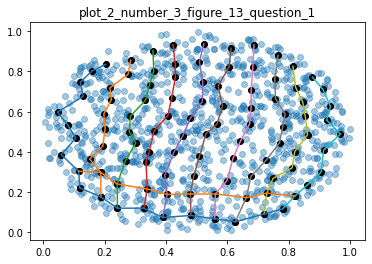

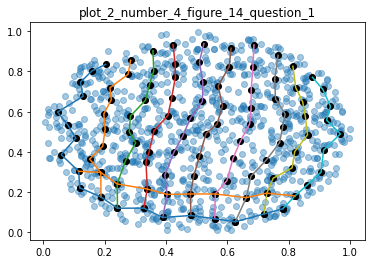

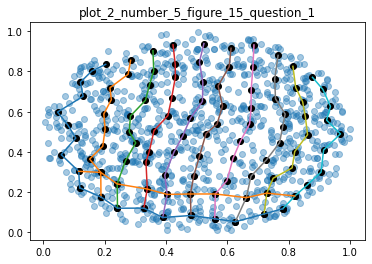

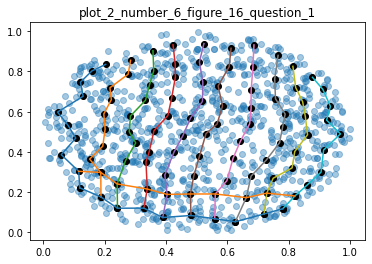

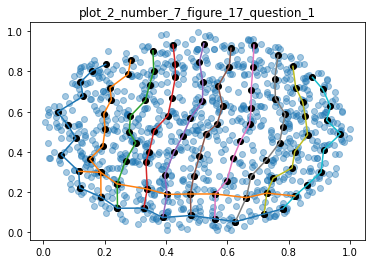

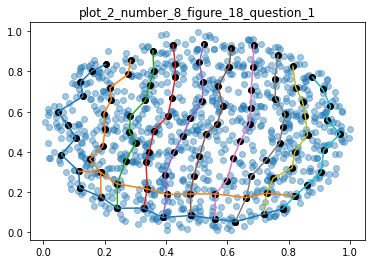

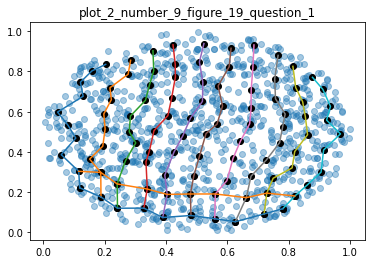

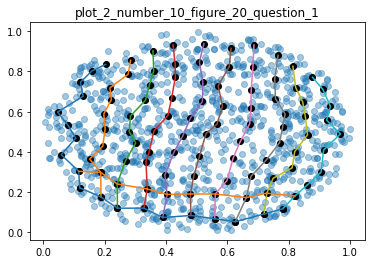

In [10]:
# Question 1 - for 10 * 10 neirons
CURRENT_QUESTION = 1
data = create_data(1000)
Map = create_map(10, 10, CURRENT_QUESTION)
iterations = 1000
lr = 0.5
radius = 4
lr_decay = 0.1
radius_decay = 0.1
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

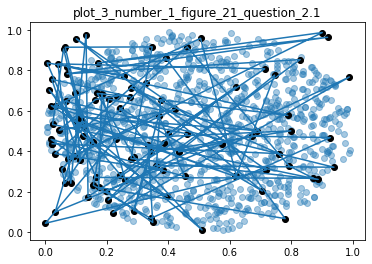

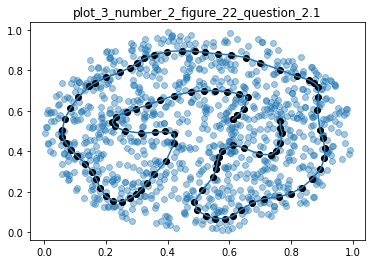

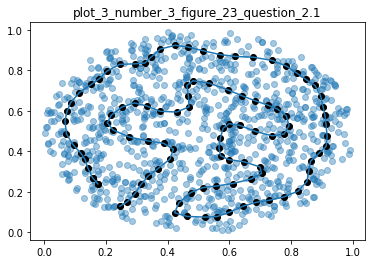

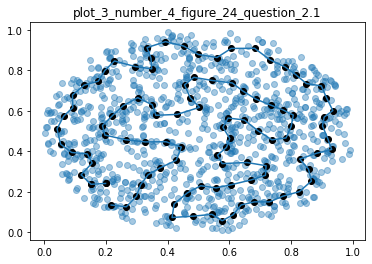

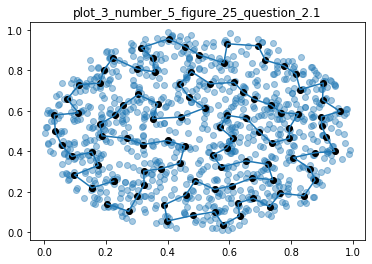

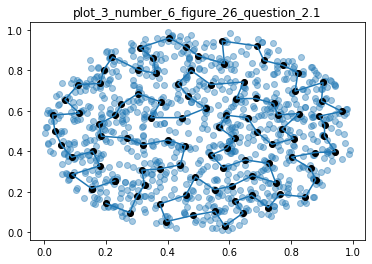

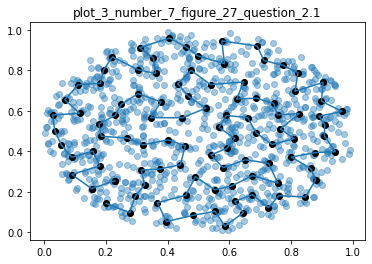

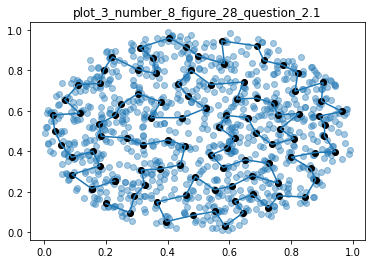

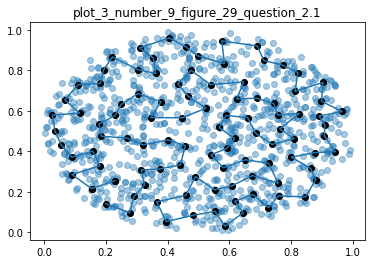

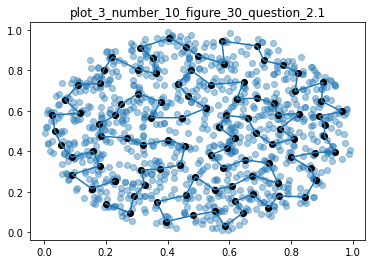

In [11]:
# Question 2.1 - for 100 neirons
CURRENT_QUESTION = 2.1
data=create_data(1000)
Map=create_map(100, 1, CURRENT_QUESTION)
iterations=1000
lr = 0.5
radius = 8
lr_decay = 0.01
radius_decay = 0.01
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

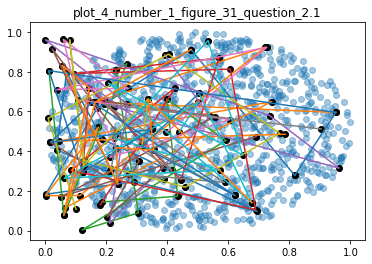

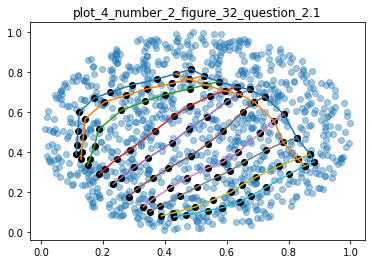

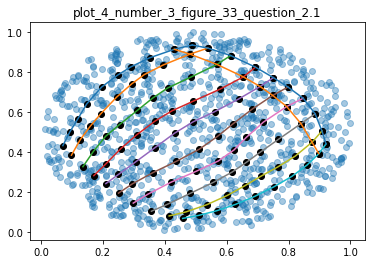

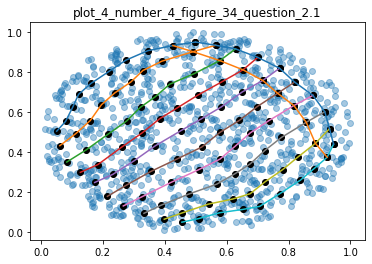

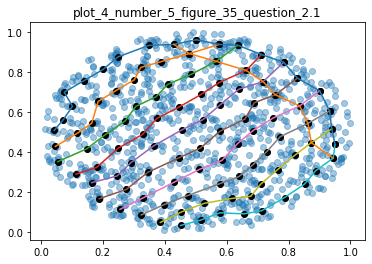

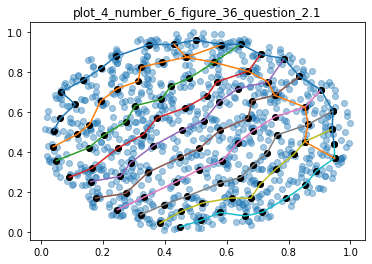

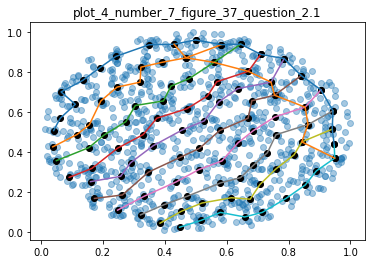

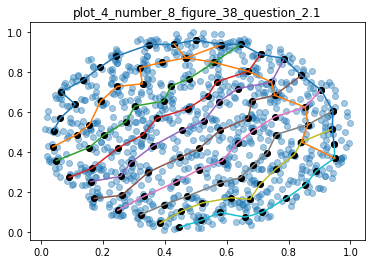

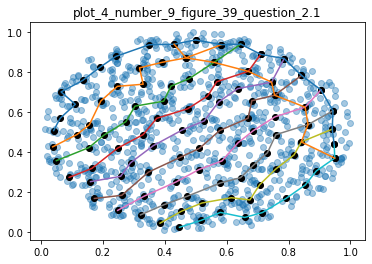

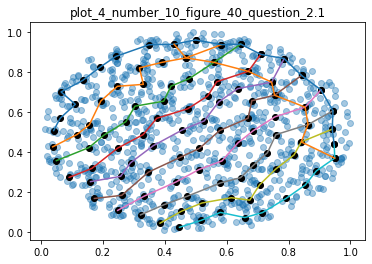

In [12]:
# Question 2.1 - for 10 * 10 neirons
CURRENT_QUESTION = 2.1
data = create_data(1000)
Map = create_map(10, 10, CURRENT_QUESTION)
iterations = 1000
lr = 0.5
radius = 8
lr_decay = 0.01
radius_decay = 0.01
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

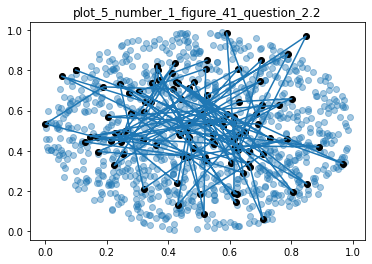

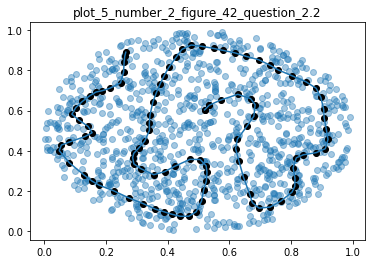

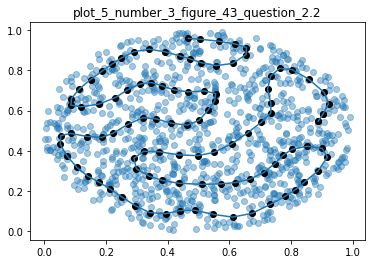

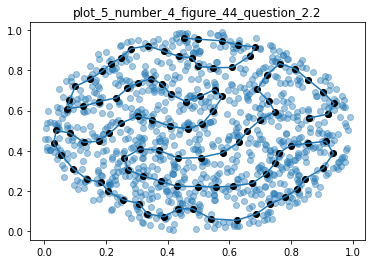

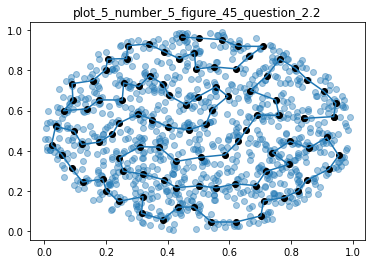

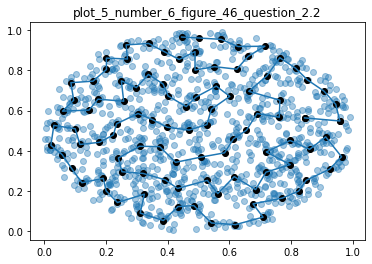

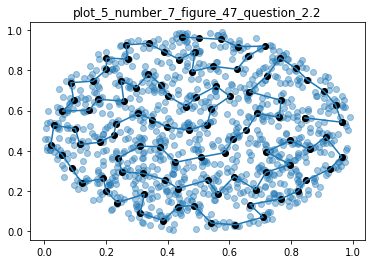

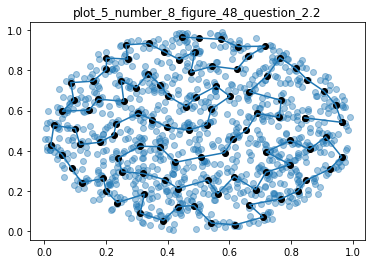

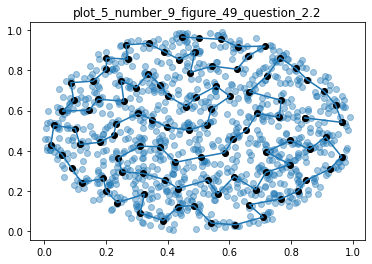

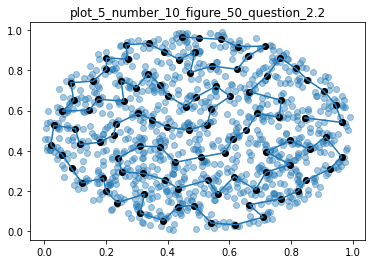

In [13]:
# Question 2.2 - for 100 neirons
CURRENT_QUESTION = 2.2
data = create_data(1000)
Map = create_map(100, 1, CURRENT_QUESTION)
iterations = 1000
lr = 0.5
radius = 8
lr_decay = 0.01
radius_decay = 0.01
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

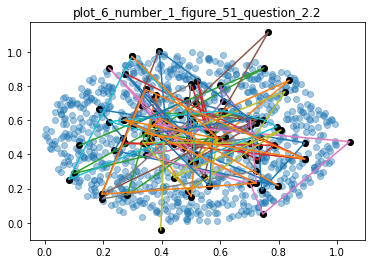

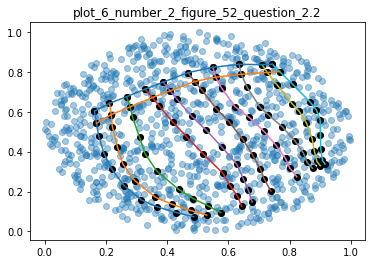

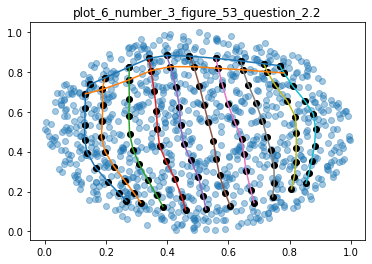

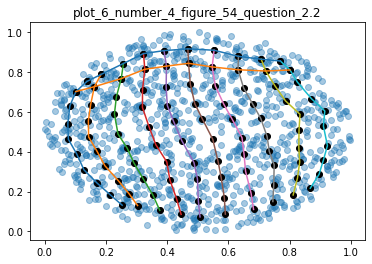

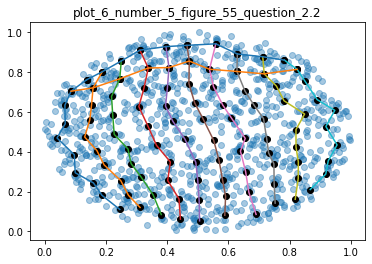

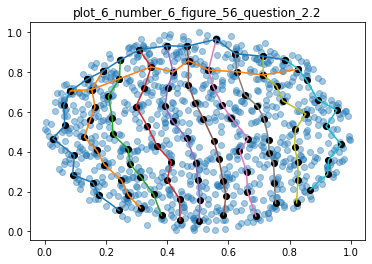

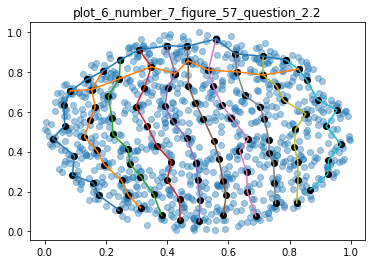

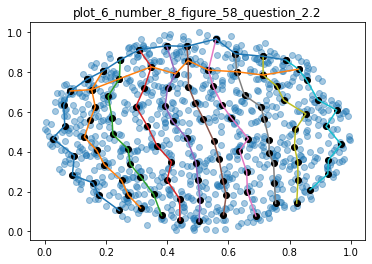

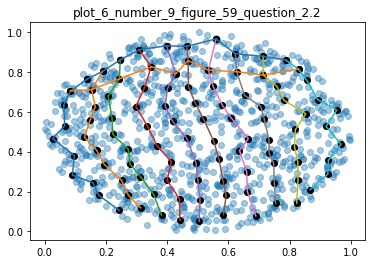

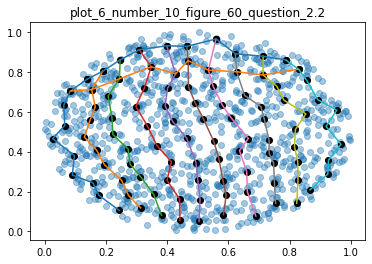

In [14]:
# Question 2.2 - for 10 * 10 neirons
CURRENT_QUESTION = 2.2
data = create_data(1000)
Map = create_map(10, 10, CURRENT_QUESTION)
iterations = 1000
lr = 0.5
radius = 8
lr_decay = 0.01
radius_decay = 0.01
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

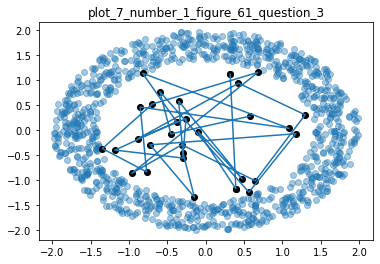

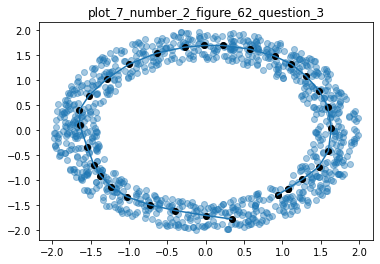

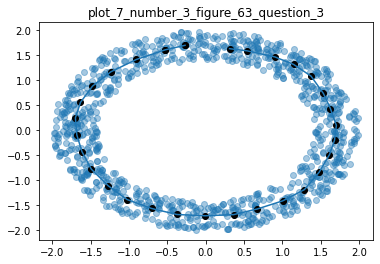

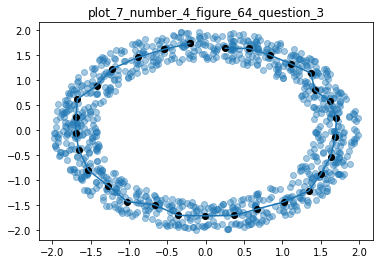

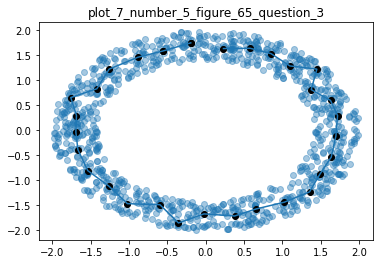

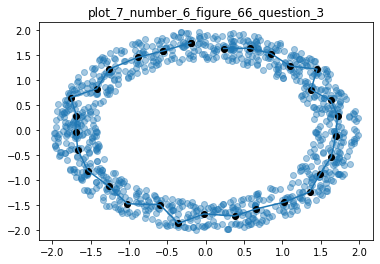

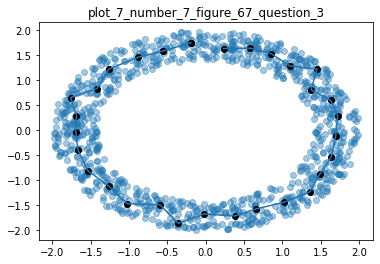

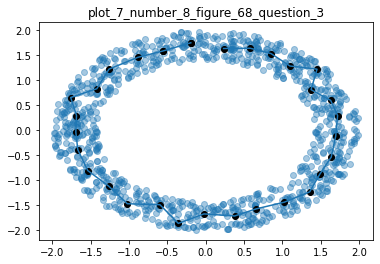

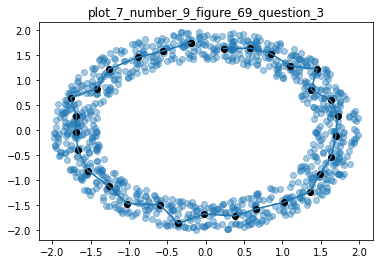

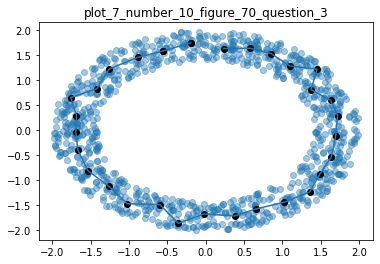

In [15]:
# Question 3 - for 30 neirons
CURRENT_QUESTION = 3
data = create_data(1000, CURRENT_QUESTION)
Map = create_map(30, 1, CURRENT_QUESTION)
iterations = 1000
lr = 0.5
radius = 4
lr_decay = 0.01
radius_decay = 0.01
train(Map,data,iterations,lr,radius,lr_decay,radius_decay, CURRENT_QUESTION)

## Part B:

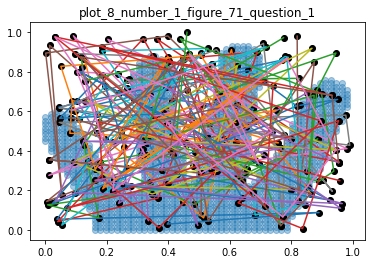

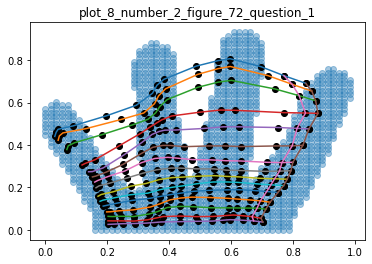

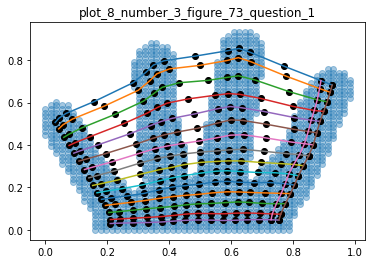

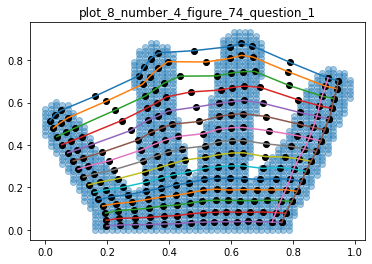

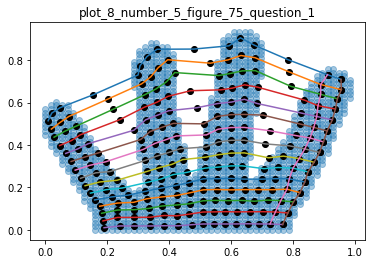

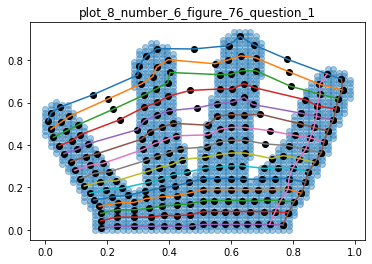

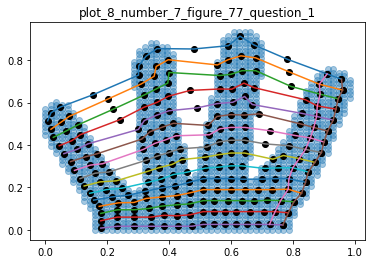

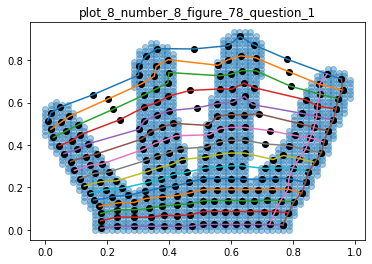

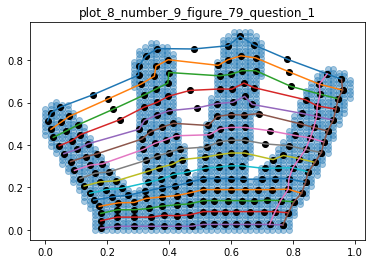

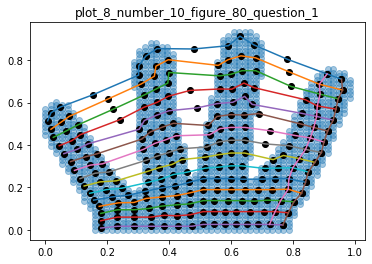

In [16]:
# Question 1 for 15 * 15 mesh
CURRENT_QUESTION = 1
data=create_hand(FINGER_IMAGE)
Map=create_map(15, 15, CURRENT_QUESTION)
iterations = 1000
lr = 0.5
radius = 8
lr_decay = 0.01
radius_decay = 0.01
train(Map, data, iterations, lr, radius, lr_decay, radius_decay, CURRENT_QUESTION)

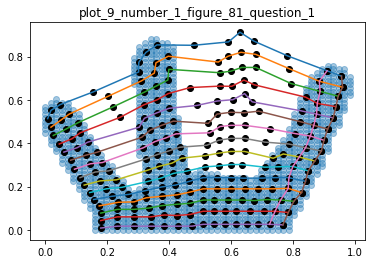

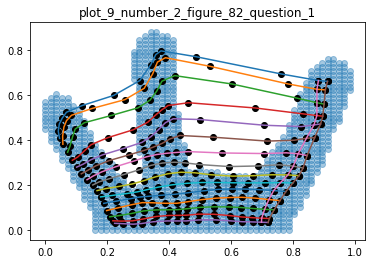

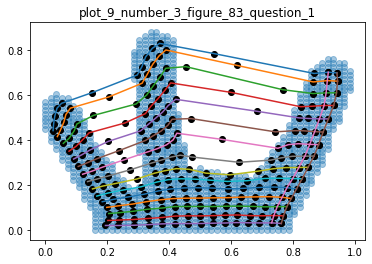

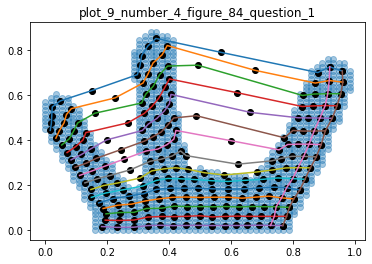

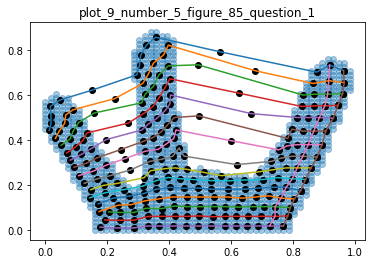

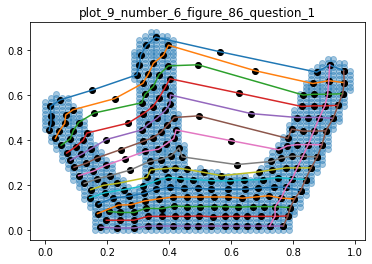

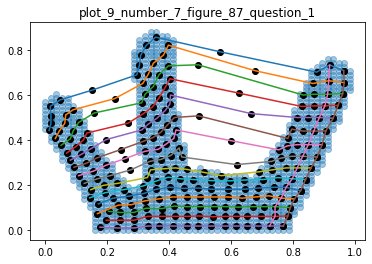

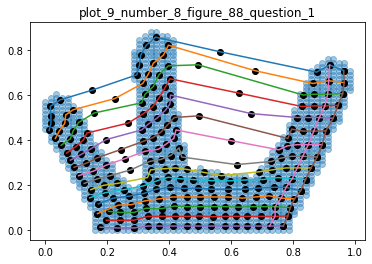

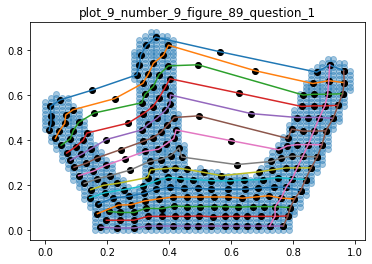

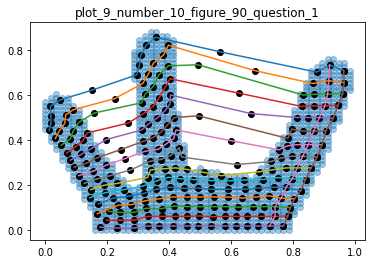

In [17]:
# Question 2 for 15 * 15 mesh
data=create_hand(FINGER_CUT_IMAGE)
iterations = 1000
lr = 0.5
radius = 4
lr_decay = 0.01
radius_decay = 0.01
train(Map, data, iterations, lr, radius, lr_decay,radius_decay, CURRENT_QUESTION)